In [1]:
import statistics
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sm
import src.data.prepare_data as prepdata
import src.features.aggregation_helper as ha
import src.features.annotation_aggregator as aa
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from src.features.annotation_aggregator import (
    DawidSkeneAggregator,
    MaceAggregator,
    MajorityVoteAggregator,
)
from tqdm.notebook import tqdm

## Load dataset
Please select a dataset and run only the corresponding cell

### Kurrek / Reddit dataset

In [2]:
dataset_name = "Reddit"

(
    class_mapping,
    gold_labels,
    annotator_labels_wide,
    annotator_labels_long,
) = prepdata.get_annotator_and_gold_labels_Reddit()
label = ["non-derog.", "derogatory"]

### Vidgen / East Asian dataset

In [2]:
dataset_name = "East Asian Prejudice"
(
    class_mapping,
    gold_labels,
    annotator_labels_wide,
    annotator_labels_long,
) = prepdata.get_annotator_and_gold_labels_EastAsian()
label = class_mapping.keys()

### Wulczyn / Wikipedia dataset

In [6]:
dataset_name = "Wikipedia"
(
    class_mapping,
    gold_labels,
    annotator_labels_wide,
    annotator_labels_long,
) = prepdata.get_annotator_and_gold_labels_Wikipedia()
label = class_mapping.keys()

Loaded data
----------------------------------
115864 comments
4053 annotators
2 classes: [0.0, 1.0]
----------------------------------
Running majority voting
Completed majority_voting in 0:00:01.305657 seconds



### Guest / Misogyny dataset

In [24]:
dataset_name = "Misogyny"
(
    class_mapping,
    gold_labels,
    annotator_labels_wide,
    annotator_labels_long,
) = prepdata.get_annotator_and_gold_labels_Misogyny()
label = ["Nonmisog.", "Misogynistic"]

## Analyzing data

Calculate the bias matrices for each annotator of the dataset

In [7]:
annotator_ids, annotator_bias_matrices = ha.get_bias_matrix_per_annotator(
    annotator_labels_wide, gold_labels, [0.0, 1.0]
)
annotator_ids_2, annotator_bias_matrices_2 = ha.get_bias_matrix_per_annotator(
    annotator_labels_wide, gold_labels, [0.0, 1.0], normalize=None
)

### Aggregated Bias Matrix
Aggregate the bias matrices of all annotators and plot it as aggregated bias matrix  

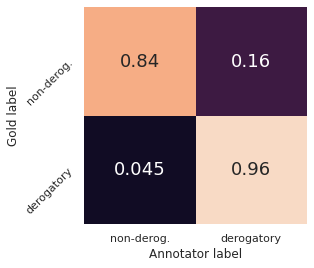

In [5]:
total_votes_matrix = np.array([[0, 0], [0, 0]])
for i in range(len(annotator_bias_matrices_2)):
    total_votes_matrix[0][0] += annotator_bias_matrices_2[i][0][0]
    total_votes_matrix[0][1] += annotator_bias_matrices_2[i][0][1]
    total_votes_matrix[1][0] += annotator_bias_matrices_2[i][1][0]
    total_votes_matrix[1][1] += annotator_bias_matrices_2[i][1][1]

# normlize
total_votes_matrix_normalized = [[0, 0], [0, 0]]
total_votes_matrix_normalized[0][0] = total_votes_matrix[0][0] / (
    total_votes_matrix[0][0] + total_votes_matrix[0][1]
)
total_votes_matrix_normalized[0][1] = total_votes_matrix[0][1] / (
    total_votes_matrix[0][0] + total_votes_matrix[0][1]
)
total_votes_matrix_normalized[1][0] = total_votes_matrix[1][0] / (
    total_votes_matrix[1][0] + total_votes_matrix[1][1]
)
total_votes_matrix_normalized[1][1] = total_votes_matrix[1][1] / (
    total_votes_matrix[1][0] + total_votes_matrix[1][1]
)
total_votes_matrix_normalized = np.array(total_votes_matrix_normalized)

fig = plt.figure(figsize=(4, 4))
df_heatmap = pd.DataFrame(total_votes_matrix_normalized, columns=label, index=label)
heatmap = sns.heatmap(
    df_heatmap,
    annot=True,
    vmin=0,
    vmax=1,
    cbar=False,
    square=False,
    annot_kws={"size": 18},
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)
plt.ylabel("Gold label")
plt.xlabel("Annotator label")
plt.show()
fig.savefig(
    f"../outputs/full_bias_matrix_{dataset_name}.pdf", dpi=300, bbox_inches="tight"
)

### Scatterplot of Annotators

In [8]:
# Transform bias matrices of annotators so that it can be converted to a dataframe
vec_length = annotator_bias_matrices.shape[1] * annotator_bias_matrices.shape[2]
annotator_bias_matrices_flattend = annotator_bias_matrices.reshape(-1, vec_length)

# Create dataframe
df_annotator_characteristics = pd.DataFrame(
    annotator_bias_matrices_flattend,
    index=annotator_ids,
    columns=["Reliability 1", "Pessimistic", "Optimistic", "Reliability 2"],
)
df_annotator_characteristics = df_annotator_characteristics.reset_index()

For datasets with a large number of annotators, the annotators should be clustered. We did this for the Wulczyn / Wikipedia dataset.

k = 10
cluster = AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="ward")

df_annotator_characteristics["Agglomerative"] = cluster.fit_predict(
    df_annotator_characteristics[
        ["Reliability 1", "Pessimistic", "Optimistic", "Reliability 2"]
    ].values
)
df_annotator_characteristics.head()

#### Scatterplot of Annotators Without Clustering
Plot the annotators according to their pessimistic and optimistic scores, if the annotators are not clustered

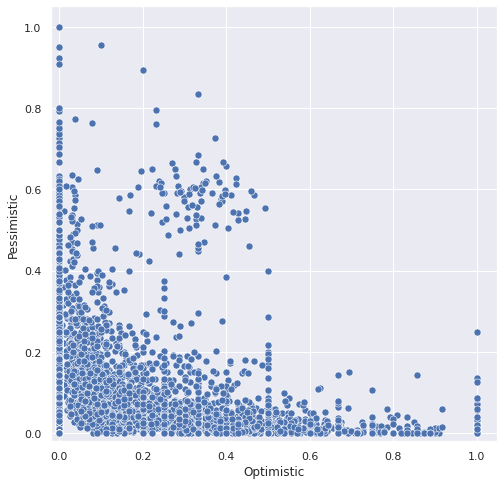

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
az = sns.scatterplot(
    ax=ax,
    data=df_annotator_characteristics,
    x="Optimistic",
    y="Pessimistic",
    # palette=["black"],
    legend=False,
    s=50,
)
if False:
    for i in range(df_annotator_characteristics.shape[0]):
        plt.text(
            x=df_annotator_characteristics.Optimistic[i] + 0.01,
            y=df_annotator_characteristics.Pessimistic[i],
            s=df_annotator_characteristics["index"][i],
            fontdict=dict(color="black", size=6),
        )

plt.ylim(-0.02, 1.05)
plt.xlim(-0.02, 1.05)
plt.show()
fig.savefig(
    f"../outputs/annotator_scatter_{dataset_name}.pdf", dpi=300, bbox_inches="tight"
)

#### Scatterplot of Annotators With Clustering


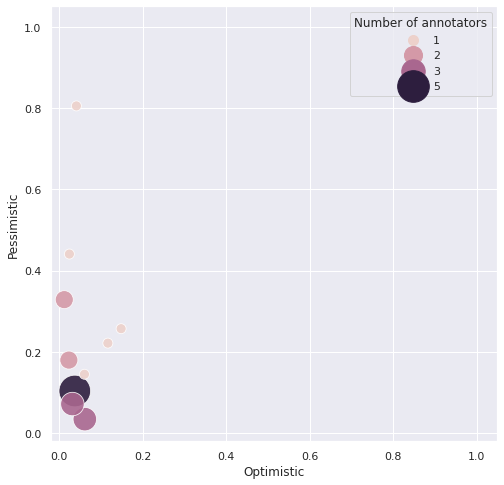

In [15]:
cluster = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="ward")

df_annotator_characteristics["Agglomerative"] = cluster.fit_predict(
    df_annotator_characteristics[
        ["Reliability 1", "Pessimistic", "Optimistic", "Reliability 2"]
    ].values
)

df_aggregated = df_annotator_characteristics.groupby("Agglomerative").agg(
    {
        "Reliability 1": "mean",
        "Pessimistic": "mean",
        "Optimistic": "mean",
        "Reliability 2": "mean",
        "index": "count",
    }
)
df_aggregated = df_aggregated.rename(columns={"index": "Number of annotators"})
fig, ax = plt.subplots(figsize=(8, 8))
az = sns.scatterplot(
    ax=ax,
    data=df_aggregated,
    x="Optimistic",
    y="Pessimistic",
    hue="Number of annotators",
    legend="auto",
    size="Number of annotators",
    sizes=(100, 1000),
    alpha=0.9,
)


plt.ylim(-0.02, 1.05)
plt.xlim(-0.02, 1.05)
plt.show()
fig.savefig(
    f"../outputs/annotator_scatter_clustered_{dataset_name}.pdf",
    dpi=300,
    bbox_inches="tight",
)

### Cluster Map of Distances between Annotators

100%|██████████| 20/20 [00:00<00:00, 4416.68it/s]
/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


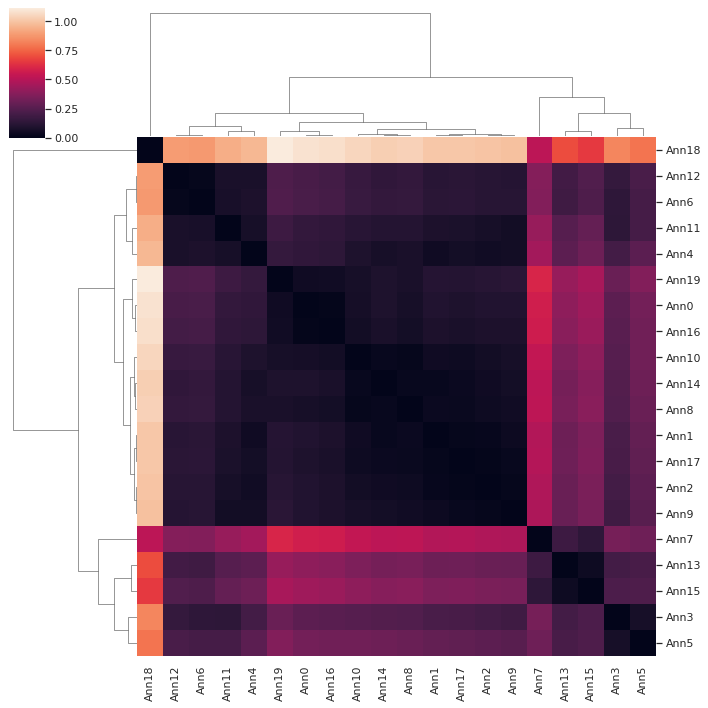

In [14]:
distance_mat = aa.compute_distance_matrix_2(annotator_ids, annotator_bias_matrices)
df_distance_mat = pd.DataFrame(distance_mat, index=annotator_ids, columns=annotator_ids)
fig = sns.clustermap(
    df_distance_mat,
    method="complete",
    annot=False,
    annot_kws={"size": 9},
)
fig.savefig(
    f"../outputs/distance_clustermap_{dataset_name}.pdf", dpi=300, bbox_inches="tight"
)

### Different Annotation behavior of Demographic Groups
This can be found in Notebook 11_Characterizing_Annotator_Bias_Demographics.ipynb